In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mlpp.hawkesnoparam.estim import Estim
import mlpp.pp.hawkes as hk
import whma.simulation as simu
from mlpp.base.utils import TimeFunction
from whma.metrics import rel_err, rank_corr

In [2]:
# simulation of Hawkes processes
d = 10
mu = 0.005 * np.ones(d)
mus = simu.simulate_mu(d, mu=mu)
blocks = [5,5]
Alpha_truth = np.zeros((d,d))
Alpha_truth[5:,5:] += 1
Alpha_truth[:5,:5] += 1
Alpha_truth[5:,:5] += 1
Alpha_truth[:5,5:] += 1
Alpha_truth /= 12
Choose_exp = np.zeros((d,d))
Choose_exp[:5,:5] = 1
Choose_exp[5:,5:] = 1
delta = .5
# add noise
#Alpha_truth += 0.01

## Major key: 
### Since hMax=40 encodes the support, we ensure \beta is not too small for estimation
We define $\beta_{\min}$ and $\beta_{\max}$ such that $$\exp(-\mbox{hMax} \times \beta_\min) = 10^{-3}$$ $$\exp(-\mbox{hDelta} \times \beta_\max) = 0.9$$

In [3]:
hMax = 40
hDelta = .1
from math import log
beta_min = log(1000) / hMax
beta_max = log(10./9.) / hDelta
print("We have")
print("    beta_min = ",beta_min)
print("    beta_max = ",beta_max)

We have
    beta_min =  0.17269388197455343
    beta_max =  1.0536051565782634


In [4]:
Beta = np.zeros((d,d))
Beta[:5] += beta_max
Beta[5:] += beta_min

In [5]:
_, s, _ = np.linalg.svd(Alpha_truth)
print(s.max())
assert s.max() < 1, "Alpha_truth cannot generate a stable Hawkes process"

0.833333333333


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


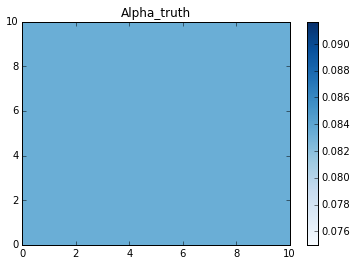

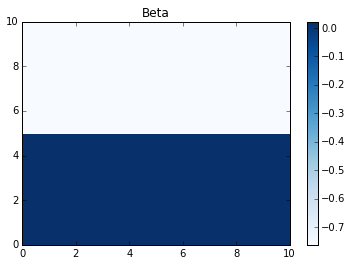

In [6]:
plt.pcolor(Alpha_truth,cmap=plt.cm.Blues)
plt.title("Alpha_truth")
plt.colorbar()
plt.show()
plt.close()
#plt.pcolor(Beta,cmap=plt.cm.bwr)
plt.pcolor(np.log10(1e-10+Beta),cmap=plt.cm.Blues)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()

In [12]:
#kernels = [[hk.HawkesKernelExp(a, b) if c else hk.HawkesKernelPowerLaw(a*delta,delta,b) for (a, b, c) in zip(a_list, b_list, c_list)] for (a_list, b_list, c_list) in zip(Alpha_truth, Beta, Choose_exp)]
#h = hk.Hawkes(kernels=kernels, mus=list(mus))
#T_max = 100
#h.simulate(T_max)
estim = Estim(h, n_threads=8, hDelta=hDelta, hMax=hMax)

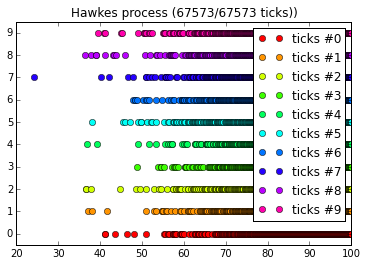

In [13]:
h.plot()

## Number of points

In [14]:
for i in range(h.dimension):
    print("i="+str(i)+"     "+str(len(h.get_full_process()[i])))

i=0     5725
i=1     5674
i=2     5739
i=3     5609
i=4     5552
i=5     7908
i=6     7986
i=7     7671
i=8     7913
i=9     7796


## Correlation matrix

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


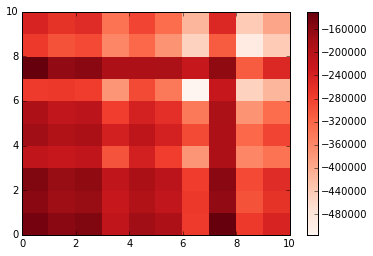

In [15]:
from whma.cumulants import get_C
Corr = get_C(estim)
plt.pcolor(Corr,cmap=plt.cm.Reds)
plt.colorbar()
plt.show()
plt.close()

# Estimation procedure

In [16]:
from whma.solver import admm
import whma.prox as prox
X0 = np.eye(d)
#X0 = np.ones(d**2).reshape(d,d)
rho = 0.01
maxiter = 1000

## objective = squared Frobenius

In [17]:
# main step
X_frob = admm(estim, prox.sq_frob, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)
plt.pcolor(X_frob,cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
plt.close()

/Users/massil/Programmation/git/whma/solver.py:14: RuntimeWarning: invalid value encountered in sqrt
  sqrt_diagD = np.sqrt(diagD)


LinAlgError: SVD did not converge

## objective = \ell_1 norm

In [18]:
# main step
X_l1 = admm(estim, prox.l1, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)
plt.pcolor(X_l1,cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
plt.close()

/Users/massil/Programmation/git/whma/solver.py:14: RuntimeWarning: invalid value encountered in sqrt
  sqrt_diagD = np.sqrt(diagD)


LinAlgError: SVD did not converge

## objective = nuclear norm

In [19]:
# main step
X_nuc = admm(estim, prox.nuclear, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)
plt.pcolor(X_nuc,cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
plt.close()

/Users/massil/Programmation/git/whma/solver.py:14: RuntimeWarning: invalid value encountered in sqrt
  sqrt_diagD = np.sqrt(diagD)


LinAlgError: SVD did not converge

In [ ]:
import pandas as pd
cols = ['RelErr', 'RankCorr', 'true EXP HF', 'mean EXP HF', 'true EXP LF', 'mean EXP LF', 'std EXP HF', 'std EXP LF']
index = ['frobenius', '\ell_1', 'nuclear norm']
results = np.zeros((3,10))
for i, X in enumerate([X_frob, X_l1, X_nuc]):
    results[i][0] = rel_err(Alpha_truth, X)
    results[i][1] = rank_corr(Alpha_truth, X)
    results[i][2] = Alpha_truth[0,0]
    results[i][3] = np.mean(X[:5,:5])
    results[i][4] = Alpha_truth[5,5]
    results[i][5] = np.mean(X[5:,5:])
    results[i][6] = np.std(X[:5,:5])
    results[i][7] = np.std(X[5:,5:])
df = pd.DataFrame(results, index=index, columns=cols)
df

In [ ]:
import pandas as pd
cols = ['RelErr', 'RankCorr', 'true PLAW HF', 'mean PLAW HF', 'true PLAW LF', 'mean PLAW LF', 'std PLAW HF', 'std PLAW LF']
index = ['frobenius', '\ell_1', 'nuclear norm']
results = np.zeros((3,10))
for i, X in enumerate([X_frob, X_l1, X_nuc]):
    results[i][0] = rel_err(Alpha_truth, X)
    results[i][1] = rank_corr(Alpha_truth, X)
    results[i][2] = Alpha_truth[0,0]
    results[i][3] = np.mean(X[:5,5:])
    results[i][4] = Alpha_truth[5,5]
    results[i][5] = np.mean(X[5:,:5])
    results[i][6] = np.std(X[:5,5:])
    results[i][7] = np.std(X[5:,:5])
df = pd.DataFrame(results, index=index, columns=cols)
df